# NVE vs Nose Hoover

Mounted at /content/drive
Saving outputs to: /content/drive/MyDrive/LJ_NVE_NVT_compare
Loaded NVE data. Example values:
  First KE/N: 0.737195   First T*: 0.49146333333333336
Step     0 | T_NVT = 1.4574 | zeta = -9.662e-04
Step  1000 | T_NVT = 1.2080 | zeta = -1.660e-01
Step  2000 | T_NVT = 1.2204 | zeta = 1.196e-01
Step  3000 | T_NVT = 1.2780 | zeta = 5.882e-01
Step  4000 | T_NVT = 1.4565 | zeta = 6.684e-01
Step  5000 | T_NVT = 1.6540 | zeta = 5.453e-01
Step  6000 | T_NVT = 1.6179 | zeta = 2.807e-01
Step  7000 | T_NVT = 1.6154 | zeta = -1.062e-01
Step  8000 | T_NVT = 1.5867 | zeta = -2.667e-01
Step  9000 | T_NVT = 1.5059 | zeta = -2.256e-01
Step 10000 | T_NVT = 1.4595 | zeta = -1.975e-02
Step 11000 | T_NVT = 1.4904 | zeta = 1.091e-01
Step 12000 | T_NVT = 1.4814 | zeta = 1.640e-01
Step 13000 | T_NVT = 1.5213 | zeta = -2.006e-01
Step 14000 | T_NVT = 1.5641 | zeta = -2.890e-01
Step 15000 | T_NVT = 1.3562 | zeta = -7.108e-02
Step 16000 | T_NVT = 1.4850 | zeta = -3.874e-02
Step 17000 | T_N

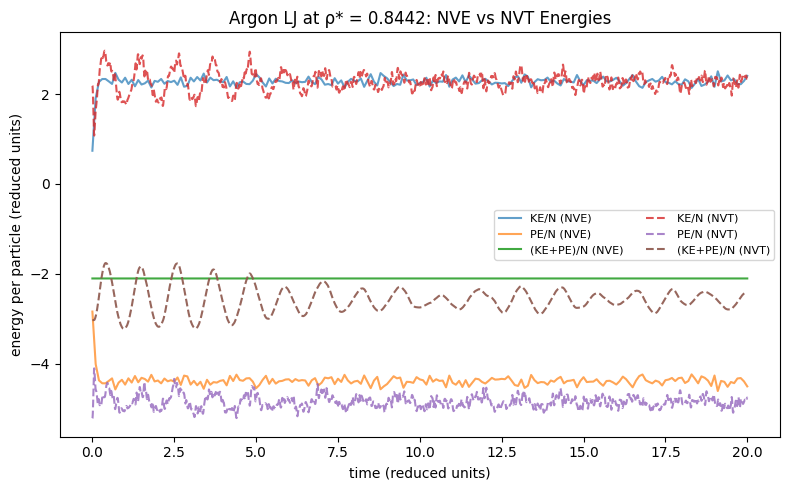

Saved: /content/drive/MyDrive/LJ_NVE_NVT_compare/energies_NVE_vs_NVT_tau0p2.png


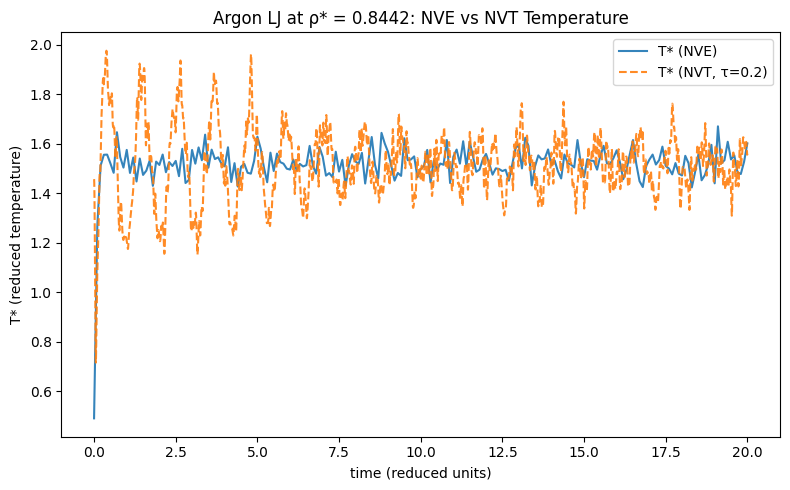

Saved: /content/drive/MyDrive/LJ_NVE_NVT_compare/temperature_NVE_vs_NVT_tau0p2.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os


NVE_ENERGY_FILE = "/content/drive/MyDrive/energy_rho0.844200_N216.out"
SAVE_DIR = "/content/drive/MyDrive/LJ_NVE_NVT_compare"
os.makedirs(SAVE_DIR, exist_ok=True)
print("Saving outputs to:", SAVE_DIR)

N        = 216
rho      = 0.8442
T_target = 1.5228
total_time = 20.0
nsteps     = 20000
dt         = total_time / nsteps
rc         = 2.5
rc2        = rc**2

tau = 0.2
dof = 3*N - 3
Q   = dof * T_target * tau**2

np.random.seed(42)

nve = np.loadtxt(NVE_ENERGY_FILE)
step_nve   = nve[:,0]
ke_nve_pp  = nve[:,1]
pe_nve_pp  = nve[:,2]
tot_nve_pp = nve[:,3]
t_star = step_nve * dt
T_nve = (2.0/3.0) * ke_nve_pp

def init_positions_cubic(N, rho):
    V = N/rho
    L = V**(1/3)
    N_axis = int(np.ceil(N**(1/3)))
    a = L / N_axis
    pos = []
    for i in range(N_axis):
        for j in range(N_axis):
            for k in range(N_axis):
                if len(pos) < N:
                    pos.append([-L/2 + a/2 + i*a,
                                -L/2 + a/2 + j*a,
                                -L/2 + a/2 + k*a])
    return np.array(pos), L

def init_velocities_mb(N, T):
    v = np.random.normal(0, np.sqrt(T), size=(N,3))
    v -= v.mean(axis=0)
    return v

def apply_pbc(r, L):
    return (r + L/2) % L - L/2

def compute_forces_LJ(r, L):
    N = r.shape[0]
    F = np.zeros_like(r)
    PE = 0.0
    for i in range(N-1):
        rij = r[i] - r[i+1:]
        rij -= L*np.rint(rij/L)
        r2 = np.sum(rij**2,axis=1)
        m = r2 < rc2
        if not np.any(m):
            continue
        rij = rij[m]
        r2  = r2[m]
        inv2 = 1.0/r2
        inv6 = inv2**3
        inv12 = inv6**2
        PE += np.sum(4*(inv12 - inv6))
        fij = ((48*inv12 - 24*inv6)*inv2)[:,None] * rij
        F[i] += np.sum(fij,axis=0)
        F[i+1:][m] -= fij
    return F, PE

def kinetic_energy(v):
    return 0.5*np.sum(v*v)

def temperature_inst(K, N):
    return (2/3)*K/N

r, L = init_positions_cubic(N, rho)
v     = init_velocities_mb(N, T_target)
F, PE = compute_forces_LJ(r, L)
zeta  = 0.0
eta   = 0.0

KE_list = []
PE_list = []
TE_list = []
T_list  = []
Hext_list = []
Eth_list  = []

for step in range(nsteps):

    K = kinetic_energy(v)
    T_inst = temperature_inst(K,N)

    KE_list.append(K)
    PE_list.append(PE)
    TE_list.append(K+PE)
    T_list.append(T_inst)

    zeta_old = zeta
    zeta += (dt/(2*Q))*(2*K - dof*T_target)
    v *= np.exp(-zeta*dt/2)
    v += 0.5*dt*F
    r += dt*v
    r = apply_pbc(r, L)
    F, PE = compute_forces_LJ(r, L)
    v += 0.5*dt*F
    v *= np.exp(-zeta*dt/2)
    K = kinetic_energy(v)
    zeta += (dt/(2*Q))*(2*K - dof*T_target)
    eta += 0.5*(zeta_old + zeta)*dt

    E_therm = 0.5*Q*zeta**2 + dof*T_target*eta
    H_ext   = K + PE + E_therm

    Eth_list.append(E_therm)
    Hext_list.append(H_ext)

    if step % 2000 == 0:
        print(f"step {step} | T={T_inst:.4f} | zeta={zeta:.3e}")

t_nvt = np.arange(nsteps)*dt
KE_nvt_pp  = np.array(KE_list)/N
PE_nvt_pp  = np.array(PE_list)/N
TE_nvt_pp  = np.array(TE_list)/N
T_nvt      = np.array(T_list)
Hext_pp    = np.array(Hext_list)/N
Eth_pp     = np.array(Eth_list)/N

plt.figure(figsize=(8,5))
plt.plot(t_star, ke_nve_pp,  label="KE/N (NVE)")
plt.plot(t_star, pe_nve_pp,  label="PE/N (NVE)")
plt.plot(t_star, tot_nve_pp, label="TE/N (NVE)")
plt.plot(t_nvt, KE_nvt_pp, '--', label="KE/N (NVT)")
plt.plot(t_nvt, PE_nvt_pp, '--', label="PE/N (NVT)")
plt.plot(t_nvt, TE_nvt_pp, '--', label="TE/N (NVT)")
plt.xlabel("t")
plt.ylabel("Energy per particle")
plt.legend(fontsize=8)
plt.title("Energies: NVE vs NVT (τ = 0.2)")
plt.tight_layout()
path1 = os.path.join(SAVE_DIR,"energies_NVE_vs_NVT.png")
plt.savefig(path1, dpi=300)
plt.show()
print("Saved:", path1)

plt.figure(figsize=(8,5))
plt.plot(t_star, T_nve, label="T (NVE)")
plt.plot(t_nvt, T_nvt, '--', label="T (NVT)")
plt.xlabel("t")
plt.ylabel("T*")
plt.legend()
plt.title("Temperature: NVE vs NVT")
plt.tight_layout()
path2 = os.path.join(SAVE_DIR,"temperature_NVE_vs_NVT.png")
plt.savefig(path2, dpi=300)
plt.show()
print("Saved:", path2)

plt.figure(figsize=(8,5))
plt.plot(t_nvt, TE_nvt_pp, label="System TE/N")
plt.plot(t_nvt, Hext_pp,   label="H_ext/N (system + thermostat)")
plt.plot(t_nvt, Eth_pp,    label="Thermostat energy / N")
plt.xlabel("t")
plt.ylabel("Energy per particle")
plt.legend(fontsize=8)
plt.title("Nose–Hoover Extended Energy Conservation")
plt.tight_layout()
path3 = os.path.join(SAVE_DIR,"extended_energy_NVT.png")
plt.savefig(path3, dpi=300)
plt.show()
print("Saved:", path3)

# NVE vs Nose Hoover vs Brownian

Saving plots to: /content/drive/MyDrive/NVT_Comparison_Plots

Running fixed Brownian NVT...

[BROWN] step=    0 | T*=1.5347 | KE/N=2.3021 | PE/N=-5.2195 | TE/N=-2.9174
[BROWN] step= 2000 | T*=1.5308 | KE/N=2.2962 | PE/N=-4.8889 | TE/N=-2.5926
[BROWN] step= 4000 | T*=1.7225 | KE/N=2.5837 | PE/N=-4.9707 | TE/N=-2.3870
[BROWN] step= 6000 | T*=1.5497 | KE/N=2.3245 | PE/N=-4.7502 | TE/N=-2.4257
[BROWN] step= 8000 | T*=1.6335 | KE/N=2.4502 | PE/N=-4.8380 | TE/N=-2.3878
[BROWN] step=10000 | T*=1.6961 | KE/N=2.5441 | PE/N=-4.6374 | TE/N=-2.0933
[BROWN] step=12000 | T*=1.4880 | KE/N=2.2319 | PE/N=-4.7722 | TE/N=-2.5403
[BROWN] step=14000 | T*=1.5523 | KE/N=2.3284 | PE/N=-4.9610 | TE/N=-2.6326
[BROWN] step=16000 | T*=1.5223 | KE/N=2.2835 | PE/N=-4.8771 | TE/N=-2.5936
[BROWN] step=18000 | T*=1.3544 | KE/N=2.0316 | PE/N=-4.8518 | TE/N=-2.8203

Brownian NVT complete.



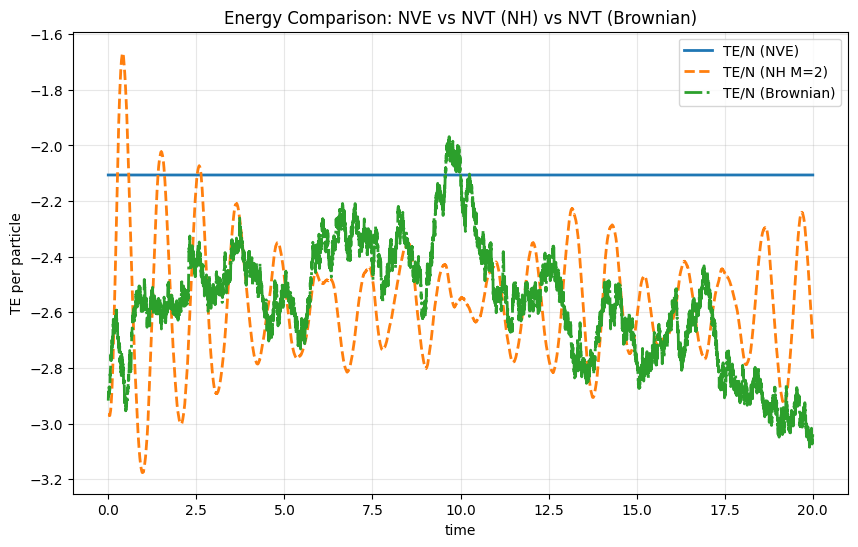

Saved: /content/drive/MyDrive/NVT_Comparison_Plots/Energy_Overlay.png


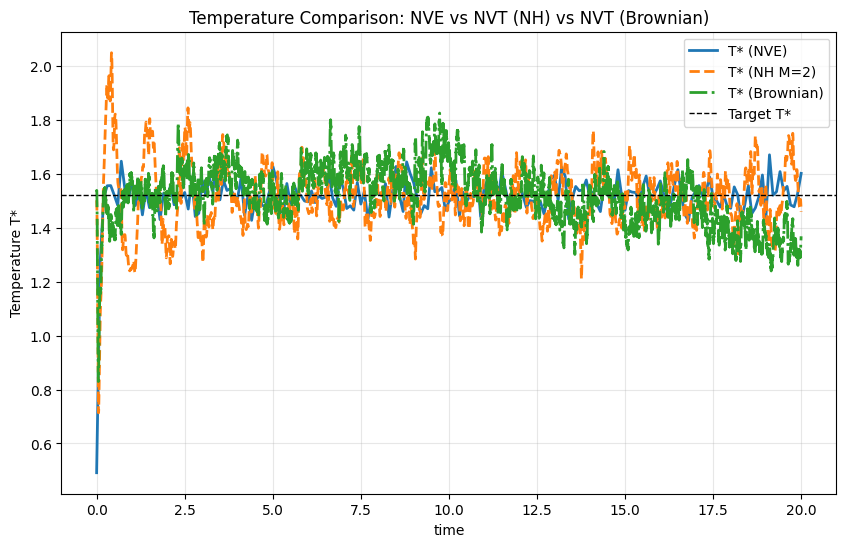

Saved: /content/drive/MyDrive/NVT_Comparison_Plots/Temperature_Overlay.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os


SAVE_DIR = "/content/drive/MyDrive/NVT_Comparison_Plots"
os.makedirs(SAVE_DIR, exist_ok=True)
print("Saving plots to:", SAVE_DIR)
NVE_FILE = "/content/drive/MyDrive/energy_rho0.844200_N216.out"
nve = np.loadtxt(NVE_FILE)

step_nve   = nve[:,0]
ke_nve_pp  = nve[:,1]
pe_nve_pp  = nve[:,2]
te_nve_pp  = nve[:,3]

N = 216
rho = 0.8442
T_target = 1.5228
total_time = 20.0
nsteps = 20000
dt_nve = total_time / nsteps
t_nve  = step_nve * dt_nve
T_nve = (2/3) * ke_nve_pp

rc = 2.5
rc2 = rc**2

def apply_pbc(r, L):
    return (r + L/2) % L - L/2

def compute_forces_LJ(r, L):
    N = r.shape[0]
    F = np.zeros_like(r)
    PE = 0.0
    for i in range(N-1):
        rij = r[i] - r[i+1:]
        rij -= L * np.rint(rij / L)
        r2 = np.sum(rij**2, axis=1)
        mask = r2 < rc2
        if not np.any(mask):
            continue
        rij = rij[mask]
        r2  = r2[mask]
        inv2  = 1/r2
        inv6  = inv2**3
        inv12 = inv6**2
        PE += np.sum(4 * (inv12 - inv6))
        fij = ((48*inv12 - 24*inv6) * inv2)[:,None] * rij
        F[i] += np.sum(fij, axis=0)
        F[i+1:][mask] -= fij
    return F, PE

def kinetic_energy(v):
    return 0.5 * np.sum(v*v)

def run_langevin_nvt(N=216, rho=0.8442, T_target=1.5228,
                     total_time=20.0, nsteps=20000, gamma=1.0):

    dt = total_time / nsteps
    V = N / rho
    L = V**(1/3)

    n3 = int(np.ceil(N**(1/3)))
    a  = L / n3
    rlist = []
    for i in range(n3):
        for j in range(n3):
            for k in range(n3):
                if len(rlist) < N:
                    rlist.append([-L/2 + a/2 + i*a,
                                  -L/2 + a/2 + j*a,
                                  -L/2 + a/2 + k*a])
    r = np.array(rlist)

    v = np.random.normal(0, np.sqrt(T_target), size=(N,3))
    v -= v.mean(axis=0)

    F, PE = compute_forces_LJ(r, L)

    KE_list, PE_list, TE_list, T_list = [], [], [], []
    sigma = np.sqrt(2 * gamma * T_target * dt)

    for step in range(nsteps):
        v += 0.5 * dt * F
        v += -gamma * v * dt + sigma * np.random.normal(size=v.shape)
        r += dt * v
        r = apply_pbc(r, L)
        F, PE = compute_forces_LJ(r, L)
        v += 0.5 * dt * F
        K = kinetic_energy(v)
        T_inst = (2/3) * (K / N)
        KE_list.append(K/N)
        PE_list.append(PE/N)
        TE_list.append((K+PE)/N)
        T_list.append(T_inst)

    return {
        "KE": np.array(KE_list),
        "PE": np.array(PE_list),
        "TE": np.array(TE_list),
        "T":  np.array(T_list),
        "dt": dt
    }

brown = run_langevin_nvt()

M_NH = 2
nh = results[M_NH]
dt_nh = nh["dt"]
t_nh = np.arange(len(nh["T"])) * dt_nh

dt_b = brown["dt"]
t_b  = np.arange(len(brown["T"])) * dt_b

plt.figure(figsize=(10,6))
plt.plot(t_nve, te_nve_pp, label="TE/N (NVE)", linewidth=2)
plt.plot(t_nh,  nh["TE"], "--", label=f"TE/N (NH M={M_NH})", linewidth=2)
plt.plot(t_b,   brown["TE"], "-.", label="TE/N (Brownian)", linewidth=2)
plt.xlabel("time")
plt.ylabel("TE per particle")
plt.title("Energy Comparison: NVE vs NVT (NH) vs NVT (Brownian)")
plt.legend()
plt.grid(alpha=0.3)
energy_path = os.path.join(SAVE_DIR, "Energy_Overlay.png")
plt.savefig(energy_path, dpi=300)
plt.show()
print("Saved:", energy_path)

plt.figure(figsize=(10,6))
plt.plot(t_nve, T_nve, label="T* (NVE)", linewidth=2)
plt.plot(t_nh,  nh["T"], "--", label=f"T* (NH M={M_NH})", linewidth=2)
plt.plot(t_b,   brown["T"], "-.", label="T* (Brownian)", linewidth=2)
plt.axhline(T_target, color='k', linestyle='--', linewidth=1, label="Target T*")
plt.xlabel("time")
plt.ylabel("Temperature T*")
plt.title("Temperature Comparison: NVE vs NVT (NH) vs NVT (Brownian)")
plt.legend()
plt.grid(alpha=0.3)
temp_path = os.path.join(SAVE_DIR, "Temperature_Overlay.png")
plt.savefig(temp_path, dpi=300)
plt.show()
print("Saved:", temp_path)